In [2]:
import pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import gzip
import os
import fnmatch
from os.path import isfile, join
import IP2Location
import ipaddress
import matplotlib.dates as mdates
%matplotlib inline

In [3]:
dataset_dir = "data/"
dataset_path = os.path.join(os.getcwd(), dataset_dir)  # Specify the full path

# 1. read hitlist

In [4]:
dataset_file="./internet_address_hitlist_it82w-20180904.fsdb.gz"
dataset = dataset_path+dataset_file

df_hitlist = pd.read_csv(dataset, sep="\s+", index_col=False, dtype="object", comment='#')
# get only the network field
df_hitlist = df_hitlist[df_hitlist.columns[1:3]]
df_hitlist.rename(columns = {list(df_hitlist)[0]:'rate',
                             list(df_hitlist)[1]: 'network',
                            }, inplace=True)
df_hitlist['rate'] = df_hitlist['rate'].astype(float)
    # df_hitlist = df_hitlist.iloc[:1,2].to_frame()
df_hitlist.drop_duplicates(subset=['network'], keep="first",inplace=True)

In [5]:
df_hitlist.head()

,rate,network
0,-2.0,1.0.1.1
1,-2.0,1.0.2.1
2,-2.0,1.0.3.1
3,99.0,1.0.4.17
4,99.0,1.0.5.5


In [6]:
df_hitlist_verf = df_hitlist[df_hitlist['rate']>0]
len(df_hitlist_verf)

6140140

In [7]:
len(df_hitlist)

14478333

# 2. read verfploeter

In [8]:
# dataset dir
dataset_file = "verfploeter_all-nodes_2019-02-07_11-50.csv.gz"
dataset = dataset_path+dataset_file
print (dataset)

/Users/joaoceron/work/SAND/viz/data/verfploeter_all-nodes_2019-02-07_11-50.csv.gz


In [9]:
df = pd.read_csv(dataset, sep=",", index_col=False)
df.drop(['destination_address','receive_time','transmit_time', 'source_address_country',
         'meta_source_address','meta_destination_address'], axis=1, inplace=True)
df = df['source_address'].to_frame()
df.columns = ['network']

In [10]:
df['network'] =  df.network.str.extract('(\d{1,3}\.\d{1,3}\.\d{1,3}\.)\d{1,3}',
                      expand=True).add('0')
df.drop_duplicates(subset=['network'], keep="first",inplace=True)

In [11]:
df.head()

,network
0,212.27.52.0
1,64.124.16.0
2,128.240.249.0
3,78.229.117.0
4,137.226.84.0


In [12]:
df.head()
print (len(df))

3439579


In [96]:
data = { 'answer'     : len(df),
         'no_answer'  : len(df_hitlist) - len(df) ,
}
s = pd.Series(data)
data = pd.DataFrame({'type':s.index, 'hits':s.values},index=s.index)

In [97]:
data

,type,hits
answer,answer,3439579
no_answer,no_answer,11038754


/Users/joaoceron/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


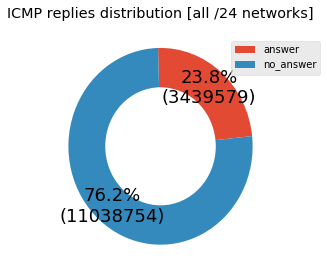

In [106]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.style.use('ggplot')
fig = plt.figure(figsize=(4.5, 4))
ax = plt.subplot2grid((1,1), (0,0))
 
# colors = ['#4f9da6','#facf5a', '#f4f141' ]

def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        if pct < 12:
            return '{p:.1f}%'.format(p=pct)
        else:
            return '{p:.1f}%\n({v:d})'.format(p=pct,v=val)
    return my_autopct

data.plot(ax=ax,
          kind='pie',
          y = 'hits',
          fontsize=18,
          autopct=make_autopct(data['hits']), 
          startangle=6, 
          pctdistance=0.80,
          title="ICMP replies distribution [all /24 networks]",
#           colors = colors,
          labels=None)

labels=data.index
ax.legend(labels, loc='upper center', bbox_to_anchor=(1,0.95))

centre_circle = plt.Circle((0,0),0.60,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
ax.set_ylabel('')


fig.savefig("distribution_total.eps", bbox_inches='tight',format='eps', dpi=1200)

fig.tight_layout()
fig.show()

# Considere only IPs used by vp

In [115]:
data = { 
         'answer' : len(df),
         'no_answer'  : len(df_hitlist_verf) - len(df) ,
}

s = pd.Series(data)
data = pd.DataFrame({'type':s.index, 'hits':s.values},index=s.index)
# data= data.drop('index',axis=1)
# data['percent'] = data.transform(lambda x: (x/np.sum(x)*100))

total = max(data['hits'])
print (data)
# data['percent'] = data['']
# data.dtypes
# data.transform(lambda x: (x/np.sum(x)*100))
# data.transform(lambda x: (np.sum(x)))

                type     hits
answer        answer  3439579
no_answer  no_answer  2700561


/Users/joaoceron/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


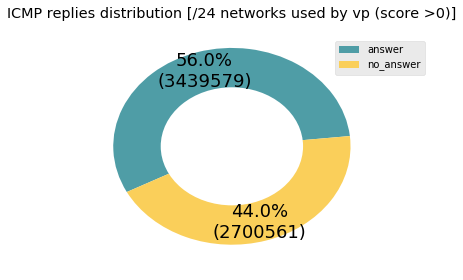

In [121]:
plt.style.use('ggplot')
fig = plt.figure(figsize=(6, 4))
ax = plt.subplot2grid((1,1), (0,0))

colors = ['#4f9da6','#facf5a', '#f4f141' ]

# total = data.loc['hitlist_vp','hits']

def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        if pct < 12:
            return '{p:.1f}%'.format(p=pct)
        else:
            return '{p:.1f}%\n({v:d})'.format(p=pct,v=val)
    return my_autopct

data.plot(ax=ax,
          kind='pie',
          y = 'hits',
          fontsize=18,
          autopct=make_autopct(data['hits']), 
          startangle=6, 
          pctdistance=0.80,
          colors = colors,
          title="ICMP replies distribution [/24 networks used by vp (score >0)]",
          labels=None)

labels=data.index
ax.legend(labels, loc='upper center', bbox_to_anchor=(1,0.95))

centre_circle = plt.Circle((0,0),0.60,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

ax.set_ylabel('')


fig.savefig("distribution_vp.eps", bbox_inches='tight',format='eps', dpi=1200)

fig.tight_layout()
fig.show()